In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install -r "/content/drive/MyDrive/NLP - shared task/Codebase/reference/requirements.txt"

In [ ]:
pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 44 kB 2.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 146 kB 15.8 MB/s 
  Created wheel for openai: filename=openai-0.25.0-py3-none-any.whl size=55880 sha256=ab3eb50a02e259534c08753b862e230179387bd4dba9bd331207d1a2dcf058f5
  Stored in directory: /root/.cache/pip/wheels/4b/92/33/6f57c7aae0b16875267999a50570e81f15eecec577ebe05a2e
Successfully built openai


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/NLP - shared task/Codebase/')

In [ ]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/NLP - shared task/Dataset/ILDC_single.csv")

In [ ]:
from pandas.tseries.frequencies import unique
print("split types:", unique(data.split))
print("classes:", unique(data.label))
print(data.head())
print("----------Sample Text-------------")
print(data.text[0])

split types: ['train' 'test' 'dev']
classes: [1 0]
                                                text  label  split  \
0   F. NARIMAN, J. Leave granted. In 2008, the Pu...      1  train   
1   S. THAKUR, J. Leave granted. These appeals ar...      0  train   
2   Markandey Katju, J. Leave granted. Heard lear...      1  train   
3   ALTAMAS KABIR,J. Leave granted. The question ...      1  train   
4   CIVIL APPEAL NO. 598 OF 2007 K. MATHUR, J. Th...      1  train   

            name  
0   2019_890.txt  
1   2014_170.txt  
2   2010_721.txt  
3  2008_1460.txt  
4   2008_188.txt  
----------Sample Text-------------
 F. NARIMAN, J. Leave granted. In 2008, the Punjab State Water Supply Sewerage Board, Bhatinda issued numberice inviting tender for extension and augmentation of water supply, sewerage scheme, pumping station and sewerage treatment plant for various towns mentioned therein on a turnkey basis. On 25.9.2008, the appellant companypany, which is Signature Not Verified involved in 

# Imports

In [ ]:
from sklearn.model_selection import train_test_split
import statistics
import math
import numpy as np
from typing import List
import spacy
import torch
import random
from collections import Counter
import re
import os
import time
import openai

# Dataset

In [ ]:
train_X = data[data.split == 'train'].text.to_list()
train_y = data[data.split == 'train'].label.to_list()
dev_X = data[data.split == 'dev'].text.to_list()
dev_y = data[data.split == 'dev'].label.to_list()
test_X = data[data.split == 'test'].text.to_list()
test_y = data[data.split == 'test'].label.to_list()

## Dataset visualization

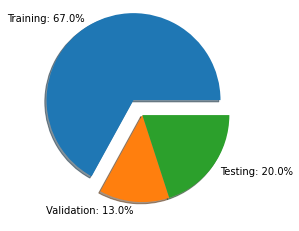

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

total = len(data)
train_per =  round(len(train_X) / total, 2)
dev_per = round(len(dev_X) / total, 2)
test_per = round(len(test_X) / total, 2)


y = np.array([train_per, dev_per, test_per])
labels = [f'Training: {train_per * 100}%', f'Validation: {dev_per * 100}%', f'Testing: {test_per * 100}%']
plt.pie(y, labels=labels, shadow=True, explode=[0.2,0,0])
plt.show()

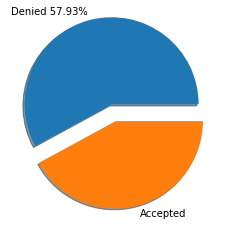

In [ ]:
from collections import Counter
distribution = Counter(data.label)

plt.pie([distribution[0], distribution[1]], labels=[f'Denied {round((distribution[0] / len(data)) * 100, 2)}%', 'Accepted'], shadow=True, explode=[0.2,0])
plt.show()

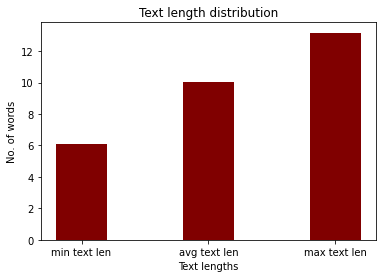

In [ ]:
import math

arr = []
max_len = 0
avg_len = 0
min_len = float('inf')
for t in data.text:
  max_len = max(max_len, len(t))
  min_len = min(min_len, len(t))
  avg_len += len(t)

avg_len = avg_len / len(data)

# print(math.log(max_len), math.log(min_len), math.log(avg_len))

plt.bar(["min text len", 'avg text len', 'max text len'], [math.log(min_len), math.log(avg_len), math.log(max_len)], color ='maroon',
        width = 0.4)
 
plt.xlabel("Text lengths")
plt.ylabel("No. of words")
plt.title("Text length distribution")
plt.show()

# Naive bayes classifier

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB


vec = CountVectorizer(stop_words='english')
x = vec.fit_transform(train_X).toarray()
dev_tr_X = vec.transform(dev_X).toarray()


model = MultinomialNB()
model.fit(x, train_y)

MultinomialNB()

In [ ]:
model.score(dev_tr_X, dev_y)

0.5895372233400402

# Logistic regression

In [ ]:
# this will be step 2 towards improvement
# we can report various results with different hyper parameters
import tqdm.notebook as tqdm
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from gensim.models import KeyedVectors
import torch
from torch.nn.functional import normalize

class LogisticRegressionClassifier(torch.nn.Module):
    def __init__(self, k:int, input_dim:int, hidden_dim:int, output_dim:int):
        super().__init__()
 
        self.countvectorizer = None
        self.tfidfvectorizer = None
        self.count_wm = None
        self.tfidf_wm = None
        self.count_tokens = None
        self.tfidf_tokens = None
        self.k = k
        self.input_dim =  input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        # https://osf.io/qvg8s/wiki/home/ : Legal domain word2vec
        self.legal_word2vec = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/NLP - shared task/Dataset/legalrawtextreplacewithnnp.bin", binary=True, unicode_errors='ignore') 
        print("legal_word2vec dimension : {}".format(len(self.legal_word2vec["legal"])))

        self.layer1 = torch.nn.Linear(self.input_dim, self.hidden_dim)
        self.classifier = torch.nn.Linear(self.hidden_dim, self.output_dim)

        self.initialize_weights()

        self.dev_f1_history = []
                                          
    def fit(self, texts, labels):
        self.countvectorizer = CountVectorizer(analyzer= 'word', stop_words= 'english')
        self.tfidfvectorizer = TfidfVectorizer(analyzer= 'word', stop_words= 'english')
        
        self.count_wm = self.countvectorizer.fit_transform(texts)
        self.tfidf_wm = self.tfidfvectorizer.fit_transform(texts)
        
        self.count_tokens = self.countvectorizer.get_feature_names_out()
        self.tfidf_tokens = self.tfidfvectorizer.get_feature_names_out()
    
    def extract_features(self, texts):
        reserved_k = 100
        k = self.k

        wm = self.tfidfvectorizer.transform(texts)
        train_featured = []
        for i,row in tqdm.tqdm(enumerate(wm)):
          feature = []
          topk_ind = row.indices[row.data.argsort()[-reserved_k:]]
          topk_words = logistic_regression_classifier.tfidf_tokens[topk_ind]

          found = 0    
          j = len(topk_words) - 1
          while(k>found):
            word = topk_words[j]
            while (word not in logistic_regression_classifier.legal_word2vec):
              #print(" [-] {} is not in word2vec".format(word))
              j=j-1
              word = topk_words[j]
            vec = logistic_regression_classifier.legal_word2vec[word]
            feature.extend(vec)
            found += 1    
            j=j-1
          train_featured.append(feature)
        train_featured_torch = torch.FloatTensor(train_featured)
        return normalize(train_featured_torch, p=1.0, dim = 1)

    def initialize_weights(self):
        stdv = 1. / math.sqrt(self.layer1.weight.size(1))
        self.layer1.weight.data.uniform_(-stdv, stdv)

        stdv = 1. / math.sqrt(self.classifier.weight.size(1))
        self.classifier.weight.data.uniform_(-stdv, stdv)

    def forward(self, features: torch.Tensor) -> torch.Tensor:
        l1 = self.layer1(features)
        output = self.classifier(l1)
        return torch.sigmoid(output)

    def predict(self, dev_features: torch.Tensor):
        preds = []
        #preds = torch.argmax(self(dev_features))
        preds = (self(dev_features).squeeze() > 0.5).float()
        return preds

    def training_loop(
        self, 
        num_epochs,
        train_features,
        train_labels,
        dev_features,
        dev_labels,
        optimizer
    ):
        print("Training...")
        #loss_func = torch.nn.NLLLoss()
        loss_func = torch.nn.BCELoss() # EDITED(TS)
        batches = list(zip(train_features, train_labels))
        random.shuffle(batches)

        for i in range(num_epochs):
            losses = []
            for features, labels in tqdm.tqdm(batches):
                # Empty the dynamic computation graph
                optimizer.zero_grad()
                preds = self(features).squeeze()
                loss = loss_func(preds, labels)
                # Backpropogate the loss through our model
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            
            print(f"epoch {i}, loss: {sum(losses)/len(losses)}")
            # Estimate the f1 score for the development set
            print("Evaluating dev...")
            preds = self.predict(dev_features)
            dev_f1 = f1_score(preds, dev_labels)
            print(f"Dev F1 {dev_f1}")
            self.dev_f1_history.append(dev_f1)
            
        # Return the trained model
        return self

In [ ]:
logistic_regression_classifier = LogisticRegressionClassifier(k=20, input_dim=4000, hidden_dim=400, output_dim=1)
logistic_regression_classifier.fit(train_X, train_y)


legal_word2vec dimension : 200


In [ ]:
train_X_features = logistic_regression_classifier.extract_features(train_X)
dev_X_features   = logistic_regression_classifier.extract_features(dev_X)
test_X_features  = logistic_regression_classifier.extract_features(test_X)
train_y_torch = torch.FloatTensor(train_y)
dev_y_torch = torch.FloatTensor(dev_y)
test_y_torch = torch.FloatTensor(test_y)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
optim = torch.optim.Adam(logistic_regression_classifier.parameters(), lr=0.0004)
model = logistic_regression_classifier.training_loop(10, train_X_features, train_y_torch, dev_X_features, dev_y_torch, optim)
torch.save(model.state_dict(), "trained_lr_model.pth")

Training...


  0%|          | 0/5082 [00:00<?, ?it/s]

epoch 0, loss: 0.1589700795369683
Evaluating dev...
Dev F1 0.4128553770086526


  0%|          | 0/5082 [00:00<?, ?it/s]

epoch 1, loss: 0.09388533501619963
Evaluating dev...
Dev F1 0.4282238442822384


  0%|          | 0/5082 [00:00<?, ?it/s]

epoch 2, loss: 0.09325801244365789
Evaluating dev...
Dev F1 0.4418604651162791


  0%|          | 0/5082 [00:00<?, ?it/s]

epoch 3, loss: 0.07389413647536835
Evaluating dev...
Dev F1 0.46490218642117376


  0%|          | 0/5082 [00:00<?, ?it/s]

epoch 4, loss: 0.07348209404582146
Evaluating dev...
Dev F1 0.45833333333333337


  0%|          | 0/5082 [00:00<?, ?it/s]

epoch 5, loss: 0.08294779254471887
Evaluating dev...
Dev F1 0.5158562367864693


  0%|          | 0/5082 [00:00<?, ?it/s]

epoch 6, loss: 0.07451107210032765
Evaluating dev...
Dev F1 0.47005649717514125


  0%|          | 0/5082 [00:00<?, ?it/s]

epoch 7, loss: 0.08439674897892029
Evaluating dev...
Dev F1 0.4721906923950057


  0%|          | 0/5082 [00:00<?, ?it/s]

epoch 8, loss: 0.06841611007558417
Evaluating dev...
Dev F1 0.47032474804031354


  0%|          | 0/5082 [00:00<?, ?it/s]

epoch 9, loss: 0.06992356797825287
Evaluating dev...
Dev F1 0.5042735042735043


In [ ]:
#model = logistic_regression_classifier
model.load_state_dict(torch.load("trained_lr_model_0.52_0.53.pth"))

preds = model.predict(train_X_features)
train_f1  = f1_score(preds, train_y_torch)
train_acc = accuracy(preds, train_y_torch)
print(f"Train F1  {train_f1}")
print(f"Train Acc {train_acc}")

preds = model.predict(dev_X_features)
dev_f1  = f1_score(preds, dev_y_torch)
dev_acc = accuracy(preds, dev_y_torch)
print(f"Dev F1  {dev_f1}")
print(f"Dev Acc {dev_acc}")

preds = model.predict(test_X_features)
test_f1  = f1_score(preds, test_y_torch)
test_acc = accuracy(preds, test_y_torch)
print(f"Test F1  {test_f1}")
print(f"Test Acc {test_acc}")
#torch.save(model.state_dict(), "trained_lr_model_0.52_0.53.pth")

5082
5082
Train F1  0.8826355525051476
Train Acc 0.8990554899645808
994
994
Dev F1  0.528263103802672
Dev Acc 0.5382293762575453
1517
1517
Test F1  0.512549537648613
Test Acc 0.5135135135135135


Unlike LSTM or Transformer which identifies the association between nearby words and extracts their meaning, it is difficult to do so in Linear regression. So, in order to extract the main words and their meanings and use them for inference, the following two pieces of information were extracted in my algorithm.

Firstly, in order find the important main keyword, TF-IDF is used here. Rather than simply counting the occurrence of a specific word to determine its importance, it enables to extract the keyword of the sentence by judging whether it appears frequently in the target sentence while not appearing frequently in other documents. In this implementation, 20 keywords were extracted by using TF-IDF.

Secondly, in the next step, we find the meaning of the keywords extracted above. The meaning of these keywords will represent the meaning of the entire document, and then approval/rejection can be determined based on it. 

In general, word2vec or glove express semantic information of the words in the form of vectors. However, the documents and words we deal with are legal terms. Since general word2vec may not have legal meaning, I used the word2vec of legal words from "SigmaLaw - Large Legal Text Corpus and Word Embeddings". (https://osf.io/qvg8s/)





# Bi-LSTM


## Create a Tokenizer with Padding

In [ ]:
class Tokenizer:

    def __init__(self, pad_symbol = "<PAD>"):

        self.pad_symbol = pad_symbol
        self.nlp = spacy.load("en_core_web_sm")
    

    def __call__(self, batch):

        batch = self.tokenize(batch)
        batch = self.pad(batch)

        return batch


    def tokenize(self, sentences):

        tokenized_sent = []
        
        for sent in sentences:
            tokenizer = self.nlp(sent)
            cleaned_sent = [token.lemma_.lower() for token in tokenizer if \
                (token.is_stop is False) and (token.is_punct is False) \
                and (token.like_url is False) and (token.like_email is False) \
                and (token.is_alpha is True)]
            
            cleaned_sent.insert(0, '<SOS>')
            cleaned_sent.append('<EOS>')
            tokenized_sent.append(cleaned_sent)
            
        return tokenized_sent


    def pad(self, batch):

        max_len = 0

        for i in batch:
            if len(i) > max_len:
                max_len = len(i)
        
        for j in batch:
            if max_len > len(j):
                j.extend(['<PAD>'] * (max_len-len(j)))
            else:
                continue
        
        # Check the sentences length are the same
        
        len_check = 0
        
        for k in batch:
            len_check += len(k)
        
        if len_check/len(batch) != len(batch[0]):
            print('Not All lengths are the same')
       
        return batch

In [ ]:
# create the vocabulary of the dataset

SPECIAL_TOKENS = ['<UNK>', '<PAD>', '<SOS>', '<EOS>']

all_data = train_X + dev_X + test_X
my_tokenizer = Tokenizer()

tokenized_data = my_tokenizer.tokenize(all_data)
vocab = sorted(set([w for ws in tokenized_data + [SPECIAL_TOKENS] for w in ws]))

with open('vocab.txt', 'w') as vf:
    vf.write('\n'.join(vocab))

## Embeddings

In [ ]:
embeddings_path = '/content/drive/MyDrive/NLP - shared task/glove.twitter.27B.50d.txt'
vocab_path = "/content/drive/MyDrive/NLP - shared task/vocab.txt"

## Creating a custom Embedding Layer

### Extracting word vectors from GloVe

In [ ]:
def read_pretrained_embeddings(embeddings_path, vocab_path):

    word2i = {}
    vectors = [] 
    
    with open(vocab_path, encoding='utf8') as vf:
        vocab = set([w.strip() for w in vf.readlines()]) 
    
    print(f"Reading embeddings from {embeddings_path}...")
    with open(embeddings_path, "r") as f:
        i = 0
        for line in f:
            word, *weights = line.rstrip().split(" ")

            if word in vocab:
                word2i[word] = i
                i += 1
                i_embeddings = [float(val) for val in line.split(' ')[1:]]
                vectors.append(torch.FloatTensor(i_embeddings))

    return word2i, torch.stack(vectors)

### Get GloVe Out of Vocabulary (oov) words


In [ ]:
def get_oovs(vocab_path, word2i):

    with open(vocab_path, encoding='utf8') as vf:
        vocab = set([w.strip() for w in vf.readlines()])
    
    glove_and_vocab = set(word2i.keys())
    vocab_and_not_glove = vocab - glove_and_vocab
    
    return list(vocab_and_not_glove)

### Update the embeddings with oov words

In [ ]:
def intialize_new_embedding_weights(num_embeddings, dim):

    w = torch.empty(num_embeddings, dim)
    
    return torch.nn.init.xavier_normal_(w)


def update_embeddings(glove_word2i, glove_embeddings, oovs):

    start_idx = len(glove_word2i)
    
    for i in oovs:
        glove_word2i[i] = start_idx
        start_idx += 1

    new_embeddings = intialize_new_embedding_weights(len(oovs), len(glove_embeddings[0]))

    return glove_word2i, torch.cat((glove_embeddings, new_embeddings), dim=0)

In [ ]:
from irony import *

def make_batches(sequences, batch_size):

    batches = []
    
    for i in range(0, len(sequences), batch_size):
        batches.append(sequences[i:i+batch_size])
        
    return batches


glove_word2i, glove_embeddings = read_pretrained_embeddings(
    embeddings_path,
    vocab_path
)

# Find the out-of-vocabularies
oovs = get_oovs(vocab_path, glove_word2i)

# Add the oovs from training data to the word2i encoding, and as new rows
# to the embeddings matrix
word2i, embeddings = update_embeddings(glove_word2i, glove_embeddings, oovs)

### Encoding words to integers

In [ ]:
# Use these functions to encode the batches before call the train loop.

def encode_sentences(batch, word2i):

    UNK_IDX = word2i["<UNK>"]
    tensors = []
    for sent in batch:
        tensors.append(torch.LongTensor([word2i.get(w, UNK_IDX) for w in sent]))
        
    return torch.stack(tensors)


def encode_labels(labels):

    return torch.LongTensor([int(l) for l in labels])

## Modeling


In [ ]:
class JudgementPredictor(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, embeddings_tensor, pad_idx, output_size, dropout_val = 0.3):
        
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.pad_idx = pad_idx
        self.dropout_val = dropout_val
        self.output_size = output_size
        self.embeddings = torch.nn.Embedding.from_pretrained(embeddings_tensor, freeze=True)
        self.dropout_layer = torch.nn.Dropout(p=self.dropout_val, inplace=False)
        self.lstm = torch.nn.LSTM(
            self.input_dim,
            self.hidden_dim,
            num_layers=2,
            dropout=dropout_val,
            batch_first=True,
            bidirectional=True,
        )
        self.classifier = torch.nn.Linear(hidden_dim*2, self.output_size)
        self.log_softmax = torch.nn.LogSoftmax(dim=2)
    

    def encode_text(self, symbols):

        embedded = self.embeddings(symbols)
        embedded = self.dropout_layer(embedded)
        lens = (symbols != self.pad_idx).sum(dim=1).to("cpu")
        packed = torch.nn.utils.rnn.pack_padded_sequence(
            embedded, lens, batch_first=True, enforce_sorted=False
        )
        packed_outs, (H, C) = self.lstm(packed)
        encoded, _ = torch.nn.utils.rnn.pad_packed_sequence(
            packed_outs,
            batch_first=True,
            padding_value=self.pad_idx,
            total_length=None,
        )

        encoded, (H, C) = self.lstm(embedded)

        last_enc_out_idxs = lens - 1
        last_enc_out_idxs = last_enc_out_idxs.view([encoded.size(0)] + [1, 1])
        last_enc_out_idxs = last_enc_out_idxs.expand(
            [-1, -1, encoded.size(-1)]
        )
        last_hidden = torch.gather(encoded, 1, last_enc_out_idxs)

        return last_hidden
    

    def forward(self, symbols):
      
        encoded_sents = self.encode_text(symbols)
        output = self.classifier(encoded_sents)

        return self.log_softmax(output)

## Evaluation

In [ ]:
from regressor import *
from itertools import chain

def predict(model, dev_sequences):

    preds = []

    for seq in dev_sequences:

        # pass the input to model
        softmax_output = model.forward(seq)
        
        # pickup the argmax at each tensor
        seq_argmax = torch.argmax(torch.exp(softmax_output), dim=2)
        seq_argmax_list = seq_argmax.squeeze(1).tolist()
        preds.append(seq_argmax_list)

    return np.fromiter(chain.from_iterable(preds), dtype='int').tolist()

## Training

In [ ]:
from tqdm.notebook import tqdm

from util import avg_f1_score, f1_score, accuracy
import matplotlib.pyplot as plt


def training_loop(
    num_epochs,
    train_features,
    train_labels,
    dev_features,
    dev_labels,
    optimizer,
    model
):
    print("Training...")
    loss_func = torch.nn.NLLLoss()
    batches = list(zip(train_features, train_labels))
    random.shuffle(batches)
    
    total_losses = [] 
    total_f1 = [] 
    total_avg_f1 = []
    total_acc = [] 
    
    for i in range(num_epochs):
        losses = []
        for features, labels in tqdm(batches):
            # Empty the dynamic computation graph
            optimizer.zero_grad()
            preds = model(features).squeeze(1)
            loss = loss_func(preds, labels)
            # Backpropogate the loss through our model
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        print(f"epoch {i}, loss: {sum(losses)/len(losses)}")
        print("Evaluating dev...")
        predicted = predict(model, dev_features)
        dev_f1 = f1_score(predicted, dev_labels, label2i['1'])
        dev_avg_f1 = avg_f1_score(predicted, dev_labels, list(label2i.values()))
        dev_acc = accuracy(predicted, dev_labels)

        print(f"Dev F1 {dev_f1}")
        print(f"Avg Dev F1 {dev_avg_f1}")
        print(f"Dev Accuracy {dev_acc}")
        
        total_losses.append(sum(losses)/len(losses))
        total_f1.append(dev_f1) 
        total_avg_f1.append(dev_avg_f1)
        total_acc.append(dev_acc) 
    
    print(f"---------- Summary ----------") 
    print(f"min losss: {min(total_losses)}")
    print(f"Max f1: {max(total_f1)}") 
    print(f"Max avg f1: {max(total_avg_f1)}") 
    print(f"Max accuracy: {max(total_acc)}") 
    
    plt.plot(total_losses)
    plt.title('losses')
    plt.show()
    
    plt.plot(total_f1 ,'r', label='F1')
    plt.plot(total_avg_f1, 'b', label='Avg F1')
    plt.title('F1 Scores')
    plt.legend()
    plt.show()
    
    plt.plot(total_acc)
    plt.title('Accuracy')
    plt.show()

    return model

In [ ]:
# Initailize the model.

model = JudgementPredictor(
    input_dim = 50,
    hidden_dim = 25,
    embeddings_tensor = embeddings,
    pad_idx = word2i['<PAD>'],
    output_size = 2,
    dropout_val = 0)

batch_size = 16
tokenizer = Tokenizer()

encode_batch_tokenized_X_train_16 = []
for batch in make_batches(train_X, batch_size):
    encode_batch_tokenized_X_train_16.append(encode_sentences(tokenizer(batch), word2i))

encode_batch_tokenized_X_dev_16 = []
for batch in make_batches(dev_X, batch_size):
    encode_batch_tokenized_X_dev_16.append(encode_sentences(tokenizer(batch), word2i))
    
encode_batch_y_train_16 = []
for batch in make_batches(train_y, batch_size):
    encode_batch_y_train_16.append(encode_labels(batch))
    
encode_y_dev = list(map(lambda x: int(x), dev_y))

# Model hyperparameter setting
num_epochs = 10
LR=0.01
# optimizer = torch.optim.SGD(model.parameters(), LR)
# optimizer = torch.optim.RMSprop(model.parameters(), LR)
optimizer = torch.optim.Adam(model.parameters(), LR)

model = training_loop(
    num_epochs,
    encode_batch_tokenized_X_train_16,
    encode_batch_y_train_16,
    encode_batch_tokenized_X_dev_16,
    encode_y_dev,
    optimizer,
    model
)

# Deep learning model with BERT

In [ ]:
# Another set of results with different hyper parameters

## Preprocessing

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict

s_words_dict = defaultdict(None)

for w in stopwords.words('english'):
  s_words_dict[w] = 1


def pre_process(texts):
  mod_texts = []
  for inp in texts:
    text_tokens = word_tokenize(inp)
    tokens_without_sw = []
    for word in text_tokens:
      if not s_words_dict.get(word):
        tokens_without_sw.append(word)
    mod_text = " ".join(tokens_without_sw)
    mod_texts.append(mod_text)
  return mod_texts

def truncate(texts):
  tr_texts = []
  for text in texts:
    arr = text.split(" ")
    tr_arr = arr[len(arr) - 510: ]
    tr_texts.append(" ".join(tr_arr))
  
  return tr_texts

train_input = truncate(pre_process(train_X))
dev_input = truncate(pre_process(dev_X))
test_input = truncate(pre_process(test_X))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# !pip install -U tensorflow
# !pip install -U tensorflow-text
import tensorflow_text as text
import tensorflow as tf

In [ ]:
import os
import shutil

import tensorflow_hub as hub
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
def convert_to_ds(inps, labels):
  tuple_ds = []
  for i in range(len(inps)):
    tuple_ds.append((inps[i], labels[i]))
  return tuple_ds

val_ds = convert_to_ds(dev_input, dev_y)

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7626287   0.99280983 -0.18611883  0.36673853  0.15233721  0.6550445
  0.9681154  -0.9486271   0.00216147 -0.98777324  0.06842694 -0.9763059 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.289463    0.34321296  0.33231434 ...  0.2130085   0.7102072
  -0.05771152]
 [-0.28742045  0.3198105  -0.23018534 ...  0.5845504  -0.2132971
   0.72692066]
 [-0.6615697   0.6887678  -0.87433004 ...  0.10877264 -0.26173142
   0.4785532 ]
 ...
 [-0.22561082 -0.28925622 -0.07064454 ...  0.47566032  0.8327713
   0.40025327]
 [-0.29824215 -0.27473125 -0.0545053  ...  0.48849735  1.0955358
   0.18163429]
 [-0.44378236  0.00930765  0.07223701 ...  0.17290132  1.1833243
   0.0789801 ]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.633355]], shape=(1, 1), dtype=float32)


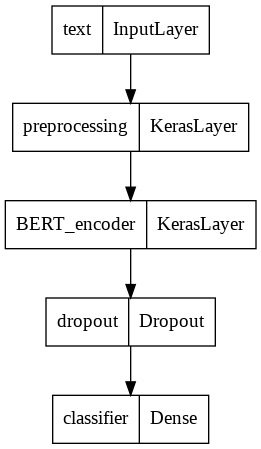

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

## Model variations

### Model version 1

In [ ]:
epochs = 5
init_lr = 3e-5

In [ ]:
classifier_model.compile(optimizer='adam',
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_input, y=train_y, epochs=epochs, validation_data=(dev_input, dev_y))

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
159/159 [==============================] - 1431s 9s/step - loss: 0.7039 - binary_accuracy: 0.6122 - val_loss: 0.7965 - val_binary_accuracy: 0.5000
Epoch 2/5
159/159 [==============================] - 1404s 9s/step - loss: 0.6978 - binary_accuracy: 0.6141 - val_loss: 0.7256 - val_binary_accuracy: 0.5000
Epoch 3/5
159/159 [==============================] - 1405s 9s/step - loss: 0.6944 - binary_accuracy: 0.6120 - val_loss: 0.7058 - val_binary_accuracy: 0.5000
Epoch 4/5
159/159 [==============================] - 1397s 9s/step - loss: 0.6974 - binary_accuracy: 0.6143 - val_loss: 0.7260 - val_binary_accuracy: 0.5000
Epoch 5/5
159/159 [==============================] - 1408s 9s/step - loss: 0.6944 - binary_accuracy: 0.6129 - val_loss: 0.7174 - val_binary_accuracy: 0.5000


### Model version 2

In [ ]:
def truncate(texts):
  tr_texts = []
  for text in texts:
    arr = text.split(" ")
    tr_arr = arr[len(arr) - 200: ]
    tr_texts.append(" ".join(tr_arr))
  
  return tr_texts

train_input_v2 = truncate(pre_process(train_X))
dev_input_v2 = truncate(pre_process(dev_X))
test_input_v2 = truncate(pre_process(test_X))

In [ ]:
epochs = 2
lr = 5e-5

In [ ]:
classifier_model.compile(optimizer='adam',
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model v2 with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_input_v2, y=train_y, epochs=epochs, validation_data=(dev_input_v2, dev_y))

Training model v2 with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2
159/159 [==============================] - 1442s 9s/step - loss: 0.7295 - binary_accuracy: 0.6043 - val_loss: 0.7232 - val_binary_accuracy: 0.5000
Epoch 2/2
159/159 [==============================] - 1416s 9s/step - loss: 0.6959 - binary_accuracy: 0.6124 - val_loss: 0.7006 - val_binary_accuracy: 0.5000


# Summarization with GPT-3

In [ ]:
cleaned_test_X_1024 = []

for i in range(len(test_X)):
    a = re.sub('[^a-zA-Z]',' ',test_X[i])
    b = ' '.join(a.split()).lower()
    c = ' '.join(w for w in b.split() if len(w)>2)
    d = ' '.join(c.split()[:1024])
    cleaned_test_X_1024.append(d)

In [ ]:
os.environ['OPENAI_API_KEY'] = 'It is a secret'
openai.api_key = os.getenv('OPENAI_API_KEY')

In [ ]:
openai.api_key = os.getenv('OPENAI_API_KEY')

summary_1024 = []

for i in range(len(cleaned_test_X_1024)):
    response = openai.Completion.create(
      model="text-davinci-002",
      prompt=f"Summary the court judgement statement in two sentences.\n\nStatement: {cleaned_test_X_1024[i]}\nSummary:",
      temperature=0,
      max_tokens=60,
      top_p=1,
      frequency_penalty=0.5,
      presence_penalty=0
)
    summary_1024.append(response['choices'][0]['text'])
    print(summary_1024)

In [ ]:
summary_1024_cleaned = []

for i in range(len(summary_1024)):
    summary_1024_cleaned.append(''.join(summary_1024[i][2:]))

In [ ]:
test_y_1024 = test_y[:369].copy()
label = {0:'Rejected', 1:'Accepted'}
result_1024 = [label[item] for item in test_y_1024]

In [ ]:
name_1024 = pd.DataFrame({'Sentence No.':test_X_name[:369], 'Reasoning':summary_1024_cleaned, 'Result':result_1024})
name_1024.to_csv('GPT-3_summary of statements with result.csv', index=False)

In [ ]:
name_1024